_Version log: Branch of V19. Parameter scan accross number of pixels._

In [322]:
import sys, warnings, time
import numpy as np
import CS_functions as cs
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
from matplotlib import ticker as ticker, pyplot as plt
from scipy import fft as spfft, interpolate as spinter
from scipy.constants import c as C
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':24, 'lines.markersize': 8.0, 'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4, 'figure.facecolor': 'none', 'axes.facecolor': 'white', "xtick.minor.visible": True, "ytick.minor.visible": True})
#np.set_printoptions(threshold=sys.maxsize)

In [37]:
def interpolate(y, new_number_of_points):
    x = range(len(y))
    new_x = np.linspace(0, len(y) -1, new_number_of_points, endpoint= True)
    inter = spinter.interp1d(x, y, kind= "linear", bounds_error= False, fill_value= "extrapolate")
    return inter(new_x)

## TRAIN WITH NOISELESS INTERFEROGRAM

In [38]:
#training_file_number = 15 # Use a noiseless version of the interferogram for good convergence
#training_file_name = "1dmockanderrors{:d}".format(training_file_number)
training_file_name = "240802134128_altered1d"

file_type = ".csv"
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

In [39]:
#LOOP INITIALISATION

unique_reduced_points = [8]
repetitions = 5
reduced_points = np.repeat(unique_reduced_points, repetitions)

dataset = cs.open_dataset(training_file_name, file_type)
total_point = dataset.shape[1]


best_scores = {"SA (regular)": np.array([]),
               "SA (centered)": np.array([]),
               "MCMC Metropolis": np.array([]),
               "Douglas Peucker": np.array([]),
               "Greedy": np.array([])}
configurations = {"SA (regular)": [],
                       "SA (centered)": [],
                       "MCMC Metropolis": [],
                       "Douglas Peucker": [],
                       "Greedy": []}
runtimes = {"SA (regular)": np.array([]),
            "SA (centered)": np.array([]),
            "MCMC Metropolis": np.array([]),
            "Douglas Peucker": np.array([]),
            "Greedy": np.array([])}

optlocs_file = "data\\" + training_file_name +"_optlocs.csv"

In [40]:
###################### THIS WILL TAKE A LONG TIME!!! #################

target, uncertainties = dataset
for reduced_point in tqdm(reduced_points):
    #compression = total_point /dataset.shape[1]
    #target = interpolate(dataset[0], total_point)
    #uncertainties = interpolate(dataset[1], total_point)

    t0 = time.time()
    detectors, score = cs.simulated_annealing(reduced_point, target, uncertainties, regularization_coeffient, "regular", cooling= 0.998, iterations= 20000)
    runtimes["SA (regular)"] = np.append(runtimes["SA (regular)"], time.time() -t0)
    best_scores["SA (regular)"] = np.append(best_scores["SA (regular)"], score)
    configurations["SA (regular)"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    t0 = time.time()
    detectors, score = cs.simulated_annealing(reduced_point, target, uncertainties, regularization_coeffient, "centered", cooling= 0.998, iterations= 20000)
    runtimes["SA (centered)"] = np.append(runtimes["SA (centered)"], time.time() -t0)
    best_scores["SA (centered)"] = np.append(best_scores["SA (centered)"], score)
    configurations["SA (centered)"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    t0 = time.time()
    detectors, score = cs.MCMC_metropolis(reduced_point, target, uncertainties, regularization_coeffient, "random", iterations= 20000)
    runtimes["MCMC Metropolis"] = np.append(runtimes["MCMC Metropolis"], time.time() -t0)
    best_scores["MCMC Metropolis"] = np.append(best_scores["MCMC Metropolis"], score)
    configurations["MCMC Metropolis"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    t0 = time.time()
    detectors, score = cs.douglas_peucker(reduced_point, target, uncertainties, regularization_coeffient)
    runtimes["Douglas Peucker"] = np.append(runtimes["Douglas Peucker"], time.time() -t0)
    best_scores["Douglas Peucker"] = np.append(best_scores["Douglas Peucker"], score)
    configurations["Douglas Peucker"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    t0 = time.time()
    detectors, score = cs.greedy(reduced_point, target, uncertainties, regularization_coeffient, "regular", iterations= 20)
    runtimes["Greedy"] = np.append(runtimes["Greedy"], time.time() -t0)
    best_scores["Greedy"] = np.append(best_scores["Greedy"], score)
    configurations["Greedy"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

#np.split(configurations["Greedy"], np.cumsum(reduced_points)[:-1]) # shouldn't need this anymore

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [104:58:46<00:00, 1889.63s/it]  


In [66]:
##### EMERGENCY DATA RECOVERY #####
np.set_printoptions(threshold=sys.maxsize)

edata = cs.open_csv("data\\1dmockanderrors15_optlocs.csv")
edata = edata[-1000:]
ereshape = np.reshape(edata, (-1, 5, edata.shape[1]))
ereshape = ereshape.transpose(1, 0, 2)

edict = {method: [config[~np.isnan(config)].astype(int) for config in configs] for method, configs in zip(runtimes.keys(), ereshape)}

print(edata.shape, ereshape.shape)
edict


(1000, 180) (5, 200, 180)


{'SA (regular)': [array([  3,  77, 123, 196]),
  array([  3,  67, 128, 196]),
  array([  3,  83, 136, 196]),
  array([ 18,  84, 141, 195]),
  array([  3,  77, 123, 196]),
  array([ 11,  78, 138, 189]),
  array([  4,  54, 121, 196]),
  array([ 11,  78, 131, 195]),
  array([  4,  83, 121, 188]),
  array([ 11,  78, 131, 195]),
  array([  5,  56,  85, 127, 157, 198]),
  array([  3,  39,  85, 117, 159, 187]),
  array([  6,  34,  84, 116, 160, 195]),
  array([  5,  39,  84, 116, 164, 193]),
  array([ 10,  46,  84, 122, 150, 194]),
  array([  3,  46,  78, 138, 145, 195]),
  array([  3,  40,  94, 114, 156, 199]),
  array([  4,  39,  78, 127, 152, 197]),
  array([  4,  50,  84, 121, 165, 196]),
  array([  3,  47,  84, 116, 160, 192]),
  array([  9,  28,  48,  80, 112, 144, 165, 194]),
  array([  3,  37,  48,  80, 112, 144, 164, 194]),
  array([  3,  39,  61,  77, 122, 132, 167, 196]),
  array([  8,  24,  49,  85, 121, 135, 173, 199]),
  array([  4,  28,  65,  80, 112, 144, 176, 196]),
  array([

In [67]:
configurations = edict

## TEST WITH NOISY INTERFEROGRAM

In [219]:
test_file_number = 17
test_file_name = "1dmockanderrors{:d}".format(test_file_number)
#test_file_name = "240802134128_processed1d"
regularization_coeffient = 1e-3

file_type = ".csv"
target, uncertainties = cs.open_dataset(test_file_name, file_type)

median_runtimes, mean_runtimes = {}, {}
for method, scores, configs in list(zip(best_scores.keys(), best_scores.values(), configurations.values())): # Re-evaluate all of the scores for a noisy version of the interferogram.
    print(method, median_runtimes[method], mean_runtimes[method])
    for n, score, config in zip(range(len(scores)), scores, configs):
        best_scores[method][n] = cs.evaluate_score(config, target, uncertainties, regularization_coeffient)

SA (regular) 202.48351645469666 191.50355304956437


SA (centered) 188.38205111026764 188.46392419099809
MCMC Metropolis 219.14951848983765 216.32646495342254
Douglas Peucker 0.33050036430358887 0.4332979702949524
Greedy 1017.8168278932571 1292.8576095414162


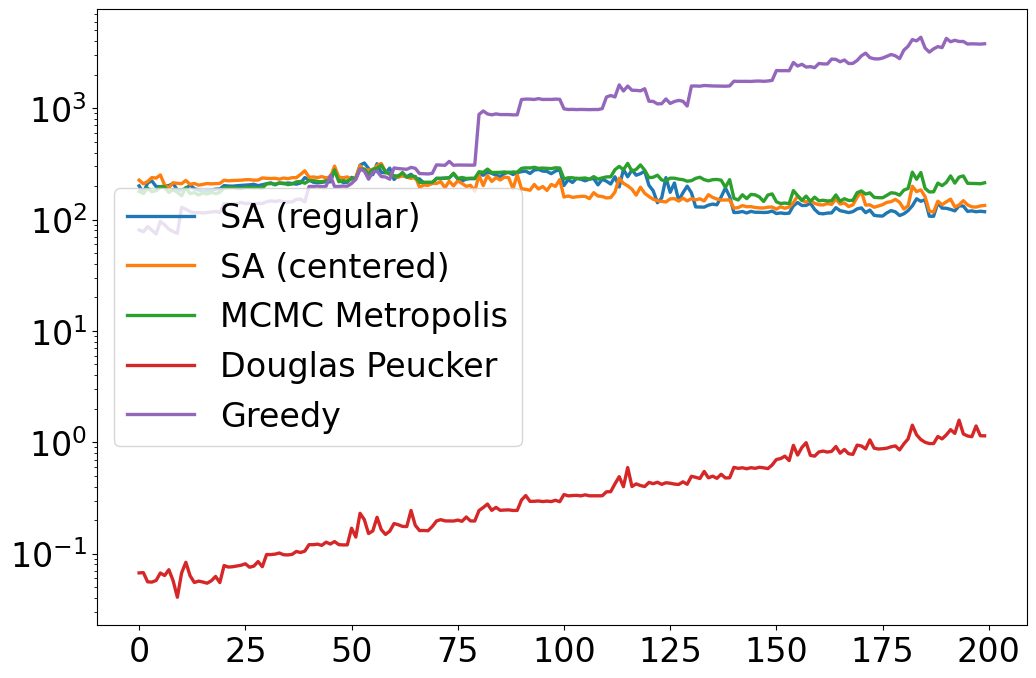

In [220]:
fig, axs = plt.subplots(1, 1, figsize= (12, 8))

for method, runtime in runtimes.items():
    axs.plot(runtime, label= method)

axs.set(yscale= "log")
plt.legend()
plt.show()

In [274]:
mean_score, median_score, std_score, max_score, min_score, best_configurations = {}, {}, {}, {}, {}, {}
for method, best_score in best_scores.items():
    if len(best_score) > 0:
        reshaped_best_scores = np.reshape(best_score, (len(unique_reduced_points), repetitions))
        mean_score[method] = np.mean(reshaped_best_scores, axis= 1)
        median_score[method] = np.median(reshaped_best_scores, axis= 1)
        std_score[method] = np.std(reshaped_best_scores, axis= 1)
        max_score[method] = np.max(reshaped_best_scores, axis= 1)
        min_score[method] = np.min(reshaped_best_scores, axis= 1)

        best_configurations[method] = [configurations[method][best_idx + n*repetitions] for n, best_idx in enumerate(np.argmin(reshaped_best_scores, axis= 1))]

        reshaped_runtimes = np.reshape(runtimes[method], (-1, repetitions))
        median_runtimes[method] = np.median(reshaped_runtimes, axis= 1)
        mean_runtimes[method] = np.mean(reshaped_runtimes, axis= 1)


In [222]:
flatline = np.zeros_like(target)
flatline_score = np.linalg.norm((target -flatline) /uncertainties) #This is the chi-squared

noiseless, _ = cs.open_dataset(training_file_name, file_type)
noiseless_score = np.linalg.norm((target -noiseless) /uncertainties) #This is the chi-squared

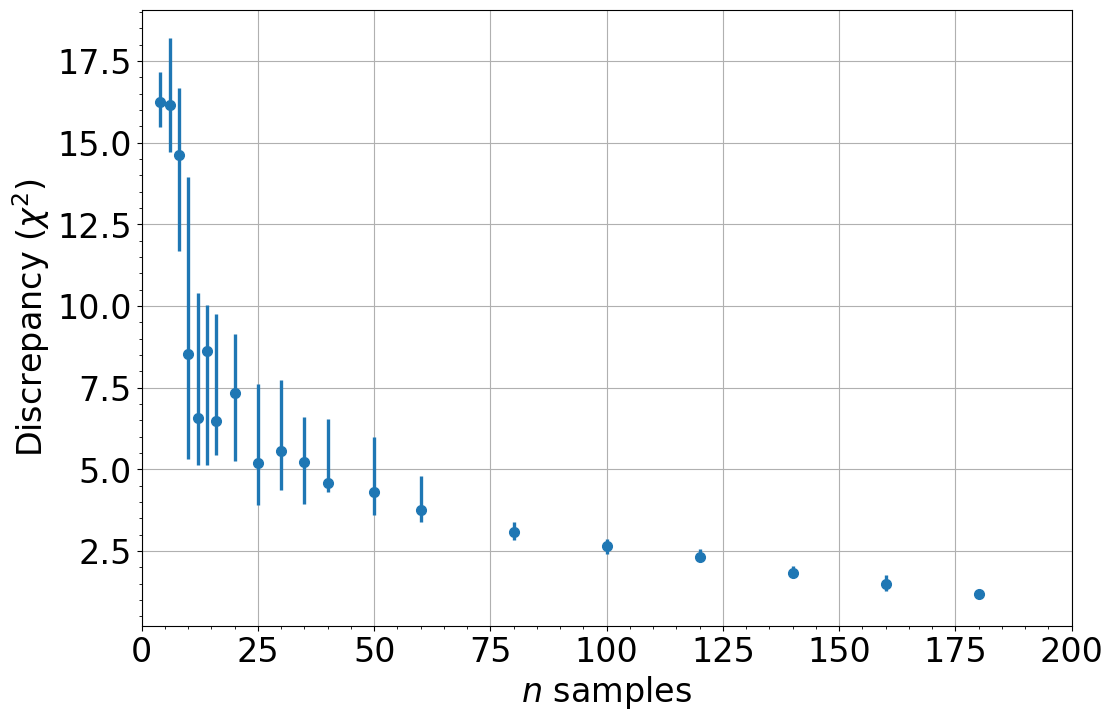

In [267]:
fig, axs = plt.subplots(figsize= (12,8))


#axs.plot(reduced_points, best_scores["SA (regular)"],
#             linestyle= "None", marker= ".", markersize= 8, color= "tab:blue", label= "Regularly spaced initialisation")

axs.errorbar(unique_reduced_points, median_score["SA (regular)"],
             yerr= (np.abs(median_score["SA (regular)"] -min_score["SA (regular)"]), np.abs(max_score["SA (regular)"] -median_score["SA (regular)"])), # can contain negative values due to floating point errors
             linestyle= "None", marker= "o", markersize= 7, color= "tab:blue", label= "Regularly spaced initialisation")

#axs.errorbar(unique_reduced_points, median_score["SA (centered)"],
#             yerr= (np.abs(median_score["SA (centered)"] -min_score["SA (centered)"]), np.abs(max_score["SA (centered)"] -median_score["SA (centered)"])), # can contain negative values due to floating point errors
#             linestyle= "None", marker= "o", markersize= 7, markeredgecolor= "darkorchid", markerfacecolor= "none", ecolor= "darkorchid", label= "Central cluster initialisation")

axs.set(xlabel= "$n$ samples",
        ylabel= r"Discrepancy ($\chi^2$)",
        #title= "Optimised Compressed Sensing to reconstruct {0:d} points".format(total_point),
        #yscale= "log",
        #yticks= [1, 2, 5, 10, 20],
        xlim= (0, 200))

axs.get_yaxis().set_major_formatter(ticker.ScalarFormatter()) #allows custom ticks in logscale
axs.grid(True)
#axs.legend()

plt.show()

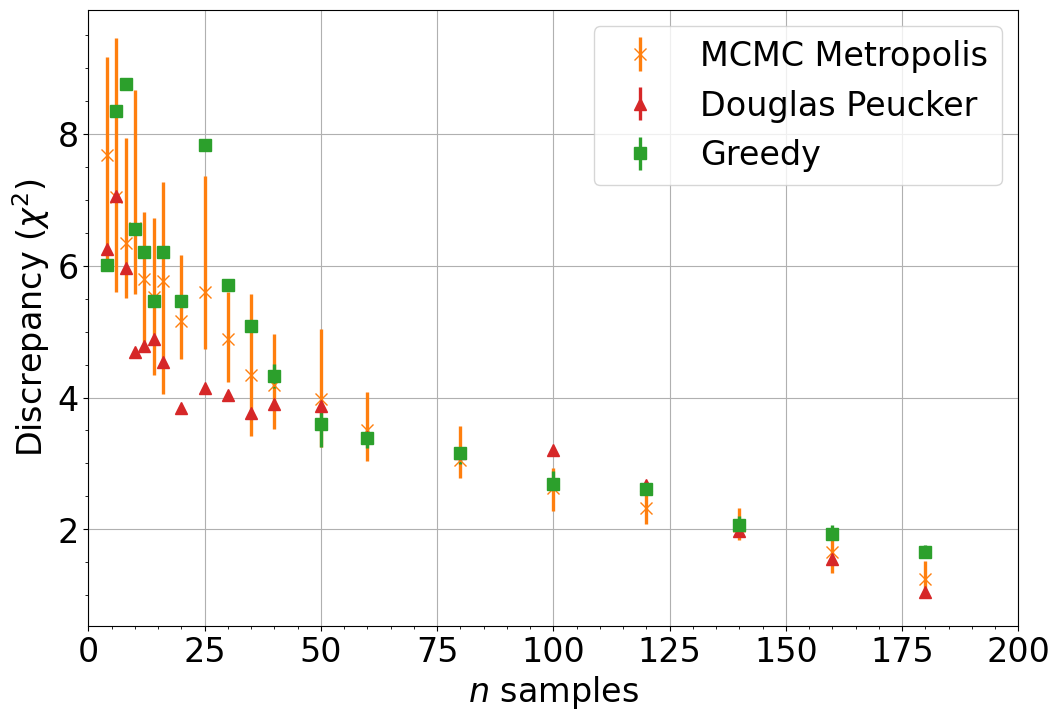

In [268]:
markers= ["x", "^", "s"]
colours = ["tab:orange", "tab:red", "tab:green"]

fig, axs = plt.subplots(figsize= (12,8))

for method, marker, colour in zip(["MCMC Metropolis", "Douglas Peucker", "Greedy"], markers, colours):
        axs.errorbar(unique_reduced_points, mean_score[method],
                     yerr= (np.abs(mean_score[method] -min_score[method]), np.abs(max_score[method] -mean_score[method])), # can contain negative values due to floating point errors
                     linestyle= "None", marker= marker, markersize= 8, color= colour, label= method)

#axs.hlines([flatline_score, noiseless_score], 0, 1, colors= "silver", transform= axs.get_yaxis_transform())
#axs.annotate("Flat line", (10,flatline_score+0.1), color= "dimgray")
#axs.annotate("Noiseless solution", (10,noiseless_score+0.1), color= "dimgray")

axs.set(xlabel= "$n$ samples",
        ylabel= r"Discrepancy ($\chi^2$)",
        #title= "Optimised Compressed Sensing to reconstruct {0:d} points".format(total_point),
        #yscale= "log",
        #yticks= [1, 2, 5, 10],
        xlim= (0, 200))

axs.get_yaxis().set_major_formatter(ticker.ScalarFormatter()) #allows custom ticks in logscale
axs.grid(True)
axs.legend()

plt.show()

## COMPARING DIFFERENT RESULTS

In [317]:
pixel_pitch = 200 #1000 #um
theta = 60 #arcminutes # APPOX. NOT MEASURED.
reduced_point = 8

idx = next(n for n, urp in enumerate(unique_reduced_points) if urp == reduced_point)

optimised_detectors = {method: configs[idx] for method, configs in best_configurations.items()}
optimisation_runtimes = {method: runtime[idx] for method, runtime in median_runtimes.items()}



In [318]:
optimised_detectors

{'SA (regular)': array([  3,  39,  53,  84, 106, 137, 182, 195]),
 'SA (centered)': array([ 83,  87,  96,  98, 100, 101, 103, 104]),
 'MCMC Metropolis': array([ 48,  83,  93, 100, 127, 129, 147, 172]),
 'Douglas Peucker': array([100,  93,  88,  84, 101,  95, 114, 126]),
 'Greedy': array([  0,  91,  57,  86, 114, 125, 159, 137])}

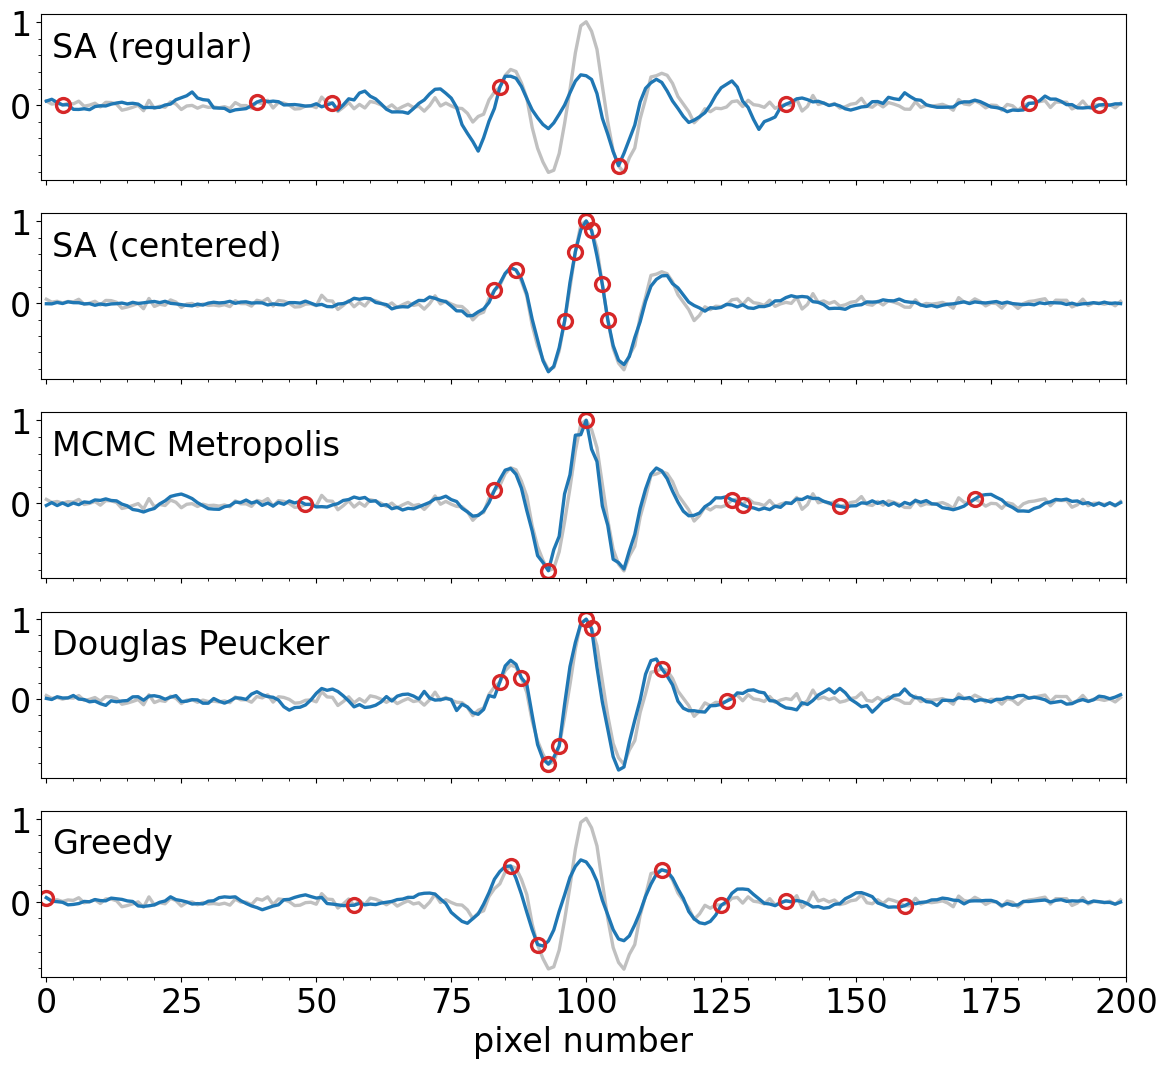

In [326]:
### INTERFEROGRAMS

number_of_methods = len(optimised_detectors)

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.2}, facecolor='none')

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), optimisation_runtimes.values(), scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient)
    ax.plot(target, color= "silver")
    ax.plot(result)
    ax.plot(sensors, samples[sensors], linestyle= "None", marker= "o", markeredgecolor= "tab:red", markerfacecolor= "None")
    ax.set(xlim= (-1, total_point), facecolor='white')
    ax.annotate(method, (0.01,0.9), xycoords= 'axes fraction', ha= "left", va= "top")
    #ax.annotate("runtime= {0:.1f}s".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
axs[-1].set(xlabel= "pixel number")

plt.show()

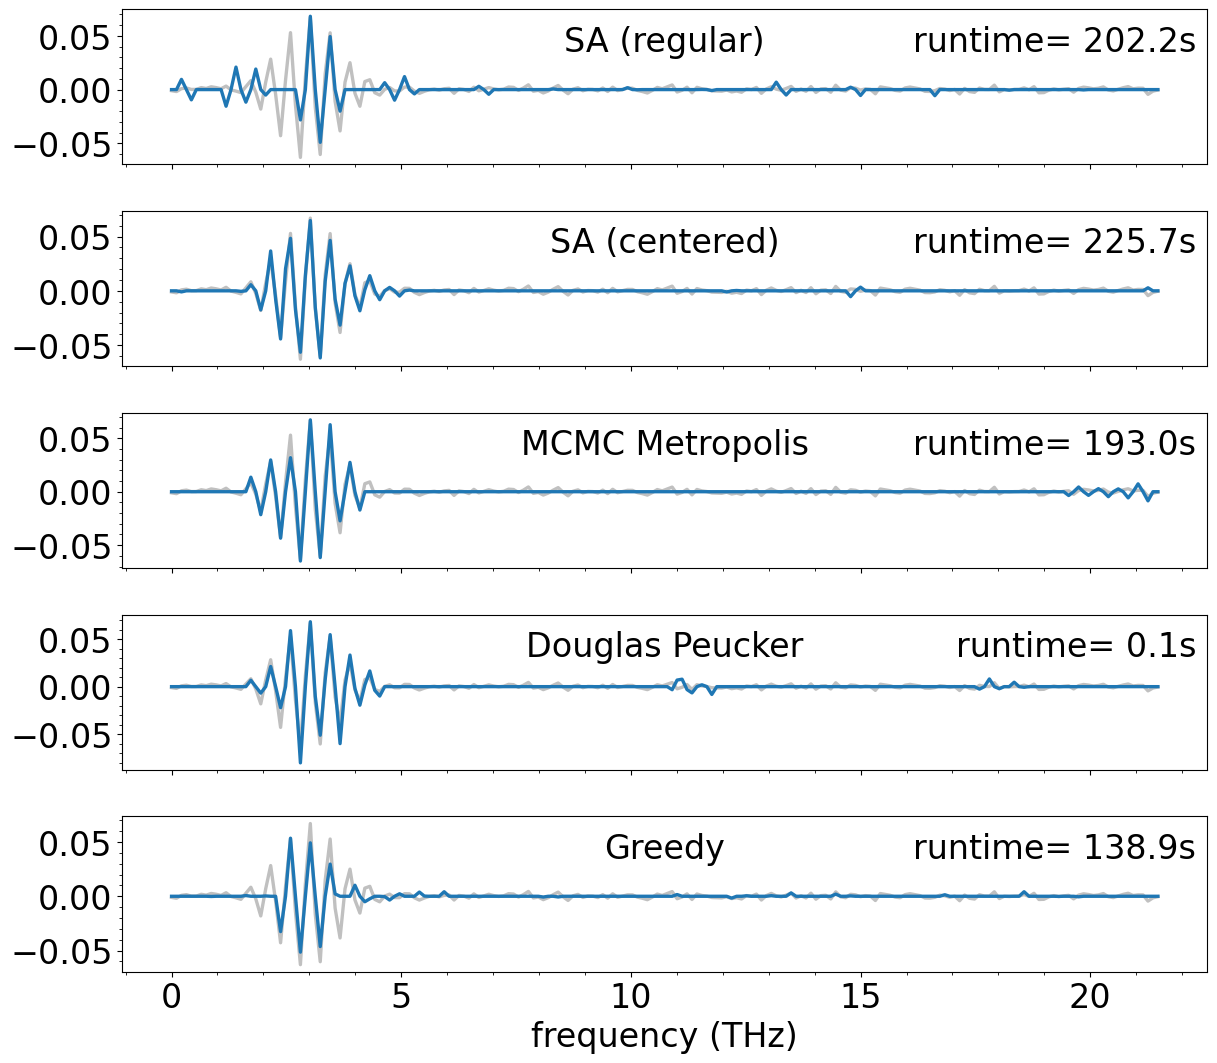

In [324]:
### DCT BASIS

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.3}, facecolor='none')

nyquist = C / (4 *pixel_pitch*1e-6 *np.sin(np.deg2rad(theta/60)))
nyquist *= 1e-12
freqs = np.linspace(0, nyquist, total_point) # THIS IS APPROXIMATE WHEN TOTAL_POINTS IS ODD.

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), optimisation_runtimes.values(), scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient, domain= "DCT")
    ax.plot(freqs, spfft.dct(target, type= 1, norm= "forward"), color= "silver")
    ax.plot(freqs, result)
    ax.set(facecolor='white')
    ax.annotate(method, (0.5,0.9), xycoords= 'axes fraction', ha= "center", va= "top")
    ax.annotate("runtime= {0:.1f}s".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
axs[-1].set(xlabel= "frequency (THz)")

plt.show()

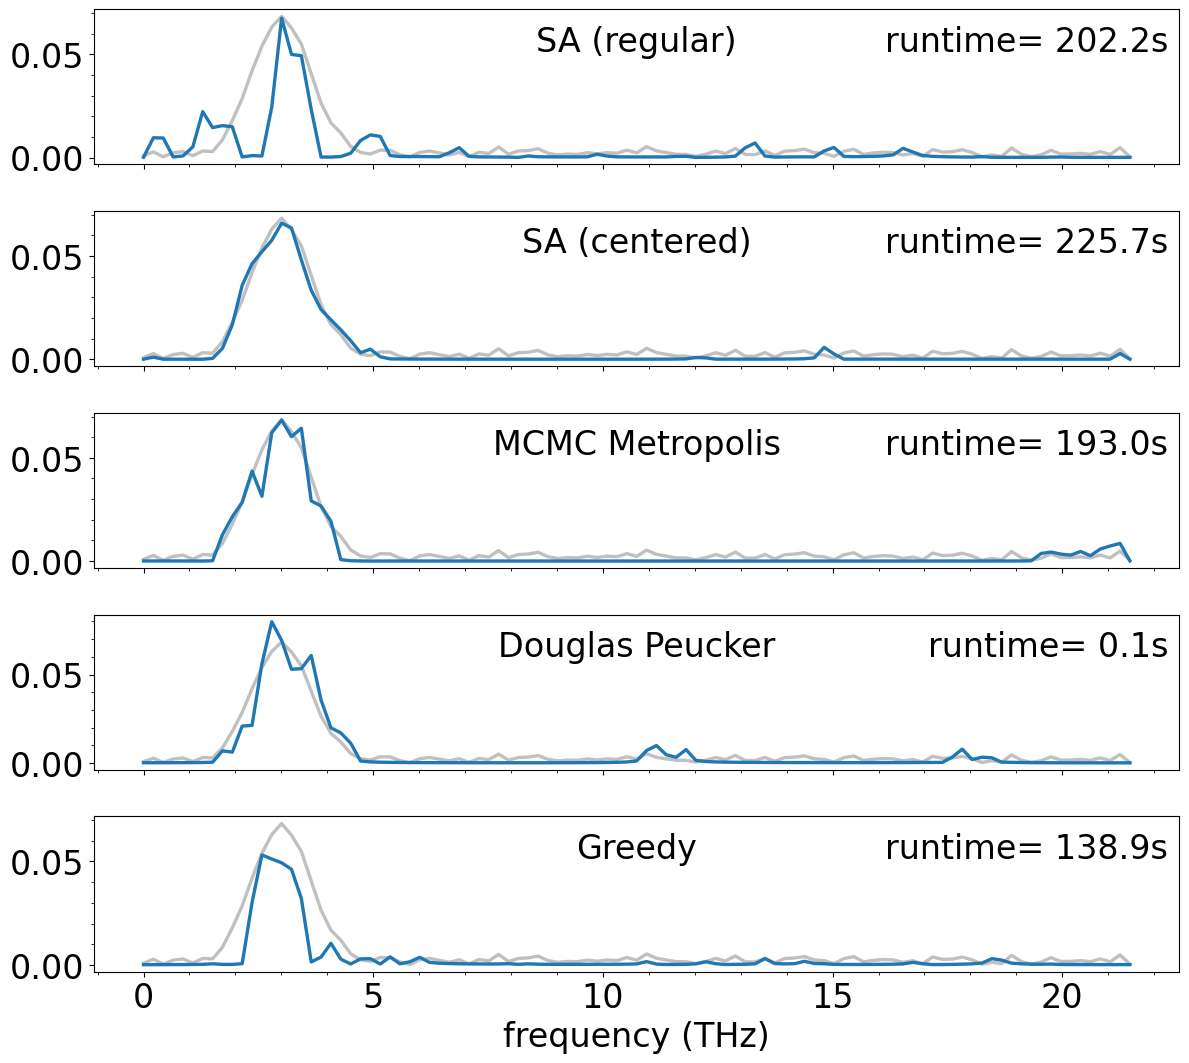

In [325]:
### POWER SPECTRUM

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.3}, facecolor='none')

freqs = np.fft.rfftfreq(total_point, pixel_pitch*1e-6)
freqs /= 2*np.sin(np.deg2rad(theta/60))
freqs *= C
freqs *= 1e-12

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), optimisation_runtimes.values(), scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient)
    ax.plot(freqs, np.abs(np.fft.rfft(target, norm= "forward")), color= "silver")
    ax.plot(freqs, np.abs(np.fft.rfft(result, norm= "forward")))
    ax.set(facecolor='white')
    ax.annotate(method, (0.5,0.9), xycoords= 'axes fraction', ha= "center", va= "top")
    ax.annotate("runtime= {0:.1f}s".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")

axs[-1].set(xlabel= "frequency (THz)")

plt.show()